## Viterbi Alignment

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  23/03/23
+ ###### Requires: pyspch v0.7   

Content:
- Evaluate the sequence effect of the HMM model


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm


In [3]:
#@title Auxiliary functions

def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    #picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

def plot_probs(probs, labels,  fig, iax=2, x0=0.,vmin=None, title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,vmin=vmin,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

In [4]:
# Helper routines for TIMIT test samples
#
timit_test_files =  ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236', 'test/dr1/faks0/sx313'] 


def extract_timit_data(name='', feature_args=None,
                          timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'):
    '''
    extracts waveform and metadata for a named TIMIT file:
    
    wavdata  wav data
    sr     sample_rate
    spg    spectrogram
    ftrs   feature extraction according to feature_args
    txt    utterance transcription
    wrd    wrd segmentation
    phn    phn segmentation
    lab    phn-label alignment
    '''
    # audio and feature extraction
    wavdata, sr = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
    spg = pyspch.sp.feature_extraction(wavdata, sample_rate=sr)
    # transcription + word segmentation 
    #txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
    #txt = re.sub('[?!.,;]', '', ' '.join(txt[0].lower().split()[2:]))
    wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sr)   
    txt = ' '.join(wrd['seg'])
    # get reference segmentation and labels , phone segmentation (+ as index)
    phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sr,xlat='timit61_timit41')

    return(wavdata,sr,spg,txt,wrd,phn)

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

In [5]:
def make_viterbi_graph(phn_seq,phn_set,STRICT=True):
    ''' 
    makes an HMM Graph to do a Viterbi Alignment on phn_seq
    it is implemented with a transition matrix with 0's and 1's
    STRICT
        True:   Enforce Viterbi 100%
        False:  Allow skips and begin/end in 2 adjacent states
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')
    init_mat = np.zeros(n_seq,dtype='float32')
    
    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    for i in range(n_seq-1):
        trans_mat[i,i+1] = 1.
        init_mat[0] = 1.0        

    if STRICT:
        end_states = np.array([n_seq-1])
    else:
        end_states = np.array([n_seq-2,n_seq-1])
        init_mat[1] = 1.0
        for i in range(n_seq-2):
            trans_mat[i,i+2]=1.
            
    return(obs_indx,trans_mat,init_mat,end_states)

## 1. Setting Up

### Feature Extraction
MFCC26=  MFCC13 + Deltas + mean-variance normalization, (defined by feature_args).

### GMM models
Available models are (training in timit-3.ipynb notebook):      
- **S41_D26_G8_FULL_1.pkl**         (FrameRecog: 53%) # S41= 41 classes/states, D26 = 26 dim features, G8 = 8 Gaussians, FULL_1 = training database + version number
- **S41_D26_G64_FULL_1.pkl**        (FrameRecog: 56%)

In [6]:
# task setup
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# define feature extraction: MFCC13 + delta's + mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
#clf_GMM = get_pickle(gmm_root+"S41_D26_G8_MINI_1.pkl")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
#clf_GMM = get_pickle(gmm_root+"S41_D26_G64_FULL_1.pkl")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
clf_GMM = get_pickle(gmm_root+"S41_D26_G8_FULL_1.pkl") 
phn_set= clf_GMM.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

## 2. Run Example File

In [7]:
# alternative non-TIMIT file
name = root_url + 'misc/friendly'
# audio and feature extraction ; return 16kHz sampling rate
wavdata, sr = pyspch.audio.load( name + ".wav",sample_rate=16000)
spgdata = pyspch.sp.feature_extraction(wavdata, sample_rate=sr)
seg_wrd = pyspch.timit.read_seg_file( name + ".wrd")   
seg_phn = pyspch.timit.read_seg_file( name + ".phn")
times = np.array([0.5,1.01])

In [8]:
timit_test_times = [ [2.08,3.07], [.1,1.3], [.1,1.2], [0.,.8], [1.4,2.5], [0.,2.5] ]
# choose an example from 0 .. 4 
example_no = 4
#
# 1. select a TIMIT test example
# 2. extract all timit data (wavdata+meta) for a named file
# 3. do the feature extraction
# 4. convert segmentation to label sequence
#
name = timit_test_files[example_no]
wavdata, sr, spgdata, txt, seg_wrd, seg_phn = extract_timit_data(name=name)
times = np.array(timit_test_times[example_no])


In [9]:
# select a time segment to focus on and find corresponding phones / transcription
ftrs = pyspch.sp.feature_extraction(wavdata, **feature_args)
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
shift=0.01
frames= (times/shift).astype('int')
frame_sel = slice(frames[0],frames[1])
seg_sel = seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]
state_sel = np.array(seg_sel.index.tolist())


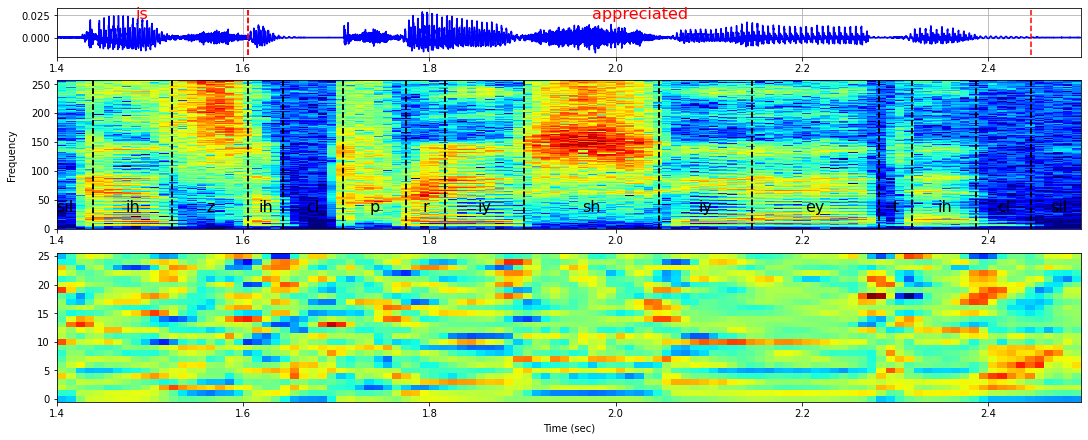

In [11]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
##############################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,
                                 frames=frames, sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=wavdata,rate=sr))

### FRAME Recognition

In [12]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# compute posterior probs in the model
X = ftrs.T
y_gmm_prob = clf_GMM.predict_proba(X,priors=[1]*41)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(y_gmm_prob, axis=1)
y_gmm_lab = [phn_set[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))

Frame Recognition Rate (for full utterance): 39.20 %


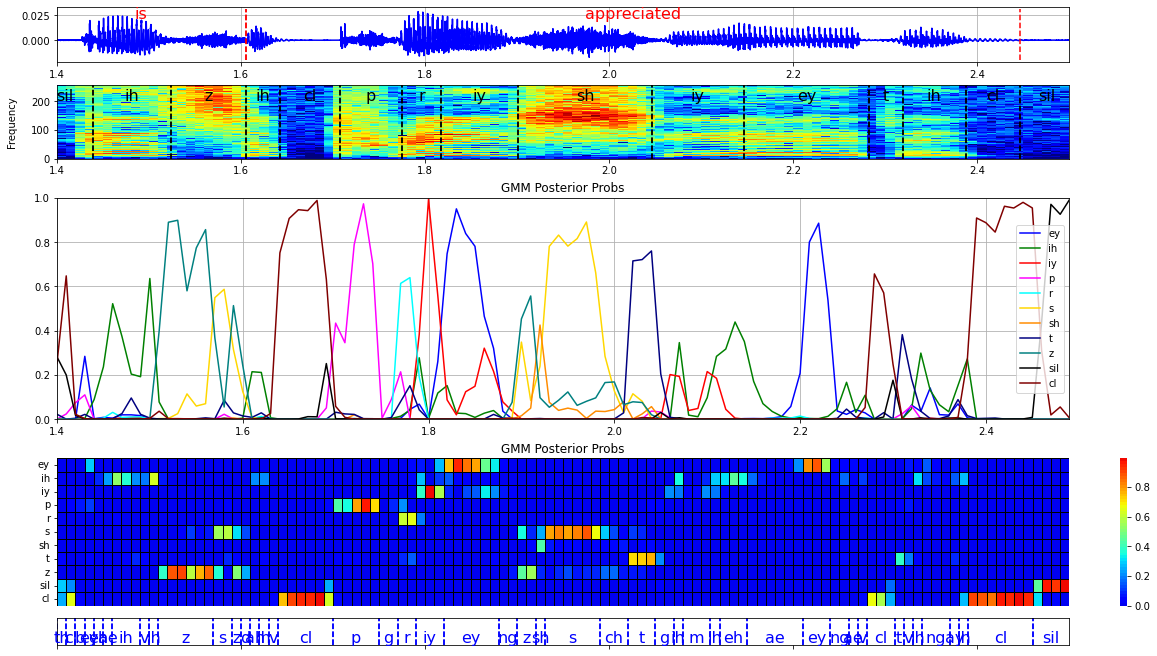

In [13]:
# make a selection of phones to plot
# include the most likely outputs and the phones in the transcriptions
top_k = 5
indx_sel = np.argsort(np.sum(y_gmm_prob[frame_sel,:],axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
phn_sel, indx_sel = select_phones_idx((seg_sel['seg'],phn_sel,['sil']),phn_set,SORTED=True)

# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,6,4,.75],
                                 frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*shift, style="line", title="GMM Posterior Probs")
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*shift, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

### Viterbi Alignment

In [14]:
# viterbi Alignment
transcript = seg_phn['seg'].tolist()
#### optionally append silence
transcript = transcript + ['sil']
state_sel = np.append(state_sel,state_sel[-1]+1)
#

In [15]:
obs_indx, trans_mat,init_mat,end_states = make_viterbi_graph(transcript,phn_set,STRICT=False)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=clf_GMM,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm2.set_probstyle('log')

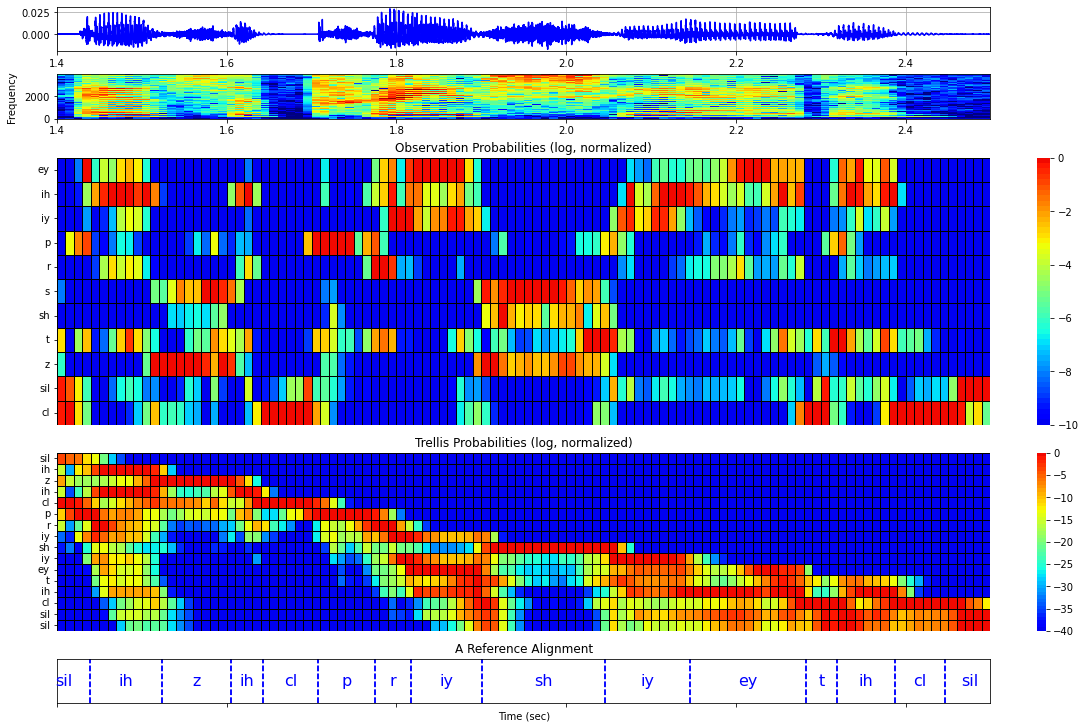

Agreement with manual alignment: 92.00 %


In [16]:
transcript_sel = np.array(transcript)[state_sel]
obs_probs_raw = clf_GMM.predict_log_prob(X)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(X)
# recognize from the trellis
y_vit_lbl = hmm2.states[trellis2.backtrace()]
y_vit_seg = Spch.lbls2seg(y_vit_lbl)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata[0:128,:],dy=4000/128,frames=frames,sample_rate=sr,figsize=(15,10),row_heights=[1,1,6,4,1],
                  img_ftrs=[None,None,None])
# plot normalized observation probabilities
obs_probs = obs_probs_raw-np.max(obs_probs_raw,axis=1,keepdims=True)
tr_probs = trellis2.probs
plot_probs(obs_probs[frame_sel,indx_sel],fig=fig,iax=2,labels=phn_sel,style="img",vmin=-10.,title="Observation Probabilities (log, normalized)")
plot_probs(tr_probs[frame_sel,state_sel],fig=fig,labels=transcript_sel,iax=3,style="img",vmin=-40.,title="Trellis Probabilities (log, normalized)")
#fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

#fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')
fig.add_seg_plot(seg_phn,iax=4,ypos=0.5,color='b',title='A Reference Alignment')
display(fig)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)
i1 = 95
i2 = 101
dfo1 = pd.DataFrame(obs_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
dft1 = pd.DataFrame(tr_probs[i1:i2,state_sel].T,index=transcript_sel,columns=np.arange(i1,i2))

In [18]:
dfo1

,95,96,97,98,99,100
ey,-6.46,-5.92,-6.65,-6.81,-5.20,-3.29
ih,-3.23,-2.61,-4.57,-7.25,-9.10,-10.28
iy,-6.67,-8.48,-12.14,-14.86,-15.11,-14.10
p,-12.96,-12.39,-14.59,-16.35,-16.64,-17.69
r,-11.68,-11.75,-12.79,-13.89,-13.50,-13.02
s,-22.14,-21.93,-24.02,-26.01,-26.58,-28.17
sh,-17.33,-17.10,-19.78,-22.01,-23.15,-24.51
t,-10.82,-11.34,-13.56,-15.17,-15.35,-15.41
z,-19.82,-19.11,-21.02,-23.16,-23.98,-25.14
sil,-10.35,-11.46,-14.10,-16.34,-16.66,-17.96


In [19]:
dft1

,95,96,97,98,99,100
sil,-7.12,-8.85,-9.53,-9.09,-7.56,-7.68
ih,-4.37,-4.37,-4.37,-4.37,-4.37,-4.37
z,-21.99,-20.87,-20.82,-20.28,-19.25,-19.24
ih,-5.39,-4.37,-4.37,-4.37,-4.37,-4.37
cl,-21.84,-20.68,-20.40,-19.93,-18.77,-18.76
p,-17.23,-15.17,-14.39,-13.48,-11.90,-11.79
r,-30.81,-26.38,-23.39,-21.03,-17.87,-14.65
iy,-25.80,-23.10,-22.74,-22.01,-19.49,-15.73
sh,-41.71,-40.29,-38.31,-37.50,-35.08,-32.11
iy,-31.05,-31.67,-30.67,-30.36,-28.02,-23.31


In [20]:
phn_sel

['ey', 'ih', 'iy', 'p', 'r', 's', 'sh', 't', 'z', 'sil', 'cl']

In [267]:
obs_probs.shape,tr_probs[-30:,-5:]

((104, 41),
 array([[   0.   ,  -11.817,  -13.697,  -27.152,  -55.468],
        [   0.   ,   -7.625,  -19.342,  -20.982,  -43.007],
        [   0.   ,   -5.359,  -13.787,  -22.531,  -34.326],
        [   0.   ,   -4.436,  -12.344,  -14.744,  -34.398],
        [   0.   ,   -2.016,  -12.502,  -11.715,  -25.55 ],
        [   0.   ,   -2.446,  -11.819,  -15.115,  -21.154],
        [   0.   ,   -1.309,  -10.681,  -16.93 ,  -24.207],
        [  -2.491,    0.   ,  -13.628,  -24.11 ,  -13.289],
        [ -10.232,    0.   ,  -20.83 ,  -33.649,  -14.24 ],
        [ -27.222,    0.   ,  -29.045,  -51.176,  -13.52 ],
        [ -43.161,    0.   ,  -26.511,  -59.149,  -16.664],
        [ -58.634,    0.   ,  -16.187,  -48.486,  -19.269],
        [ -79.348,    0.   ,  -22.806,  -43.063,  -23.758],
        [ -84.352,    0.   ,  -10.721,  -36.374,  -26.27 ],
        [ -84.123,    0.   ,   -1.777,  -17.117,  -32.449],
        [ -84.093,    0.   ,   -0.469,   -5.522,  -29.21 ],
        [ -82.953,   -4.169,

In [273]:
ph2indx

NameError: name 'ph2indx' is not defined